In [1]:
clear

## Caricamento Dati

La seguente funzione permette di caricare matrici sparse, provenienti dal sito [https://sparse.tamu.edu/](https://sparse.tamu.edu/), salvate su file nel formato matlab.<br>
Questa funzione riesce a gestire sia i vecchi formati (`< matlab v7.3`) che quelli nuovi.

In [2]:
function A = loadFunctionFromData(dataPath)
    disp(["🦍 Loading file: "  dataPath])
    load(dataPath)
    
%   se nel file è presente una `struct` allora vuol dire 
%   che sto utilizzando il nuovo formato e va convertito
%   per essere utilizzato da Octave
    if isstruct(Problem.A)
        n = length(Problem.A.jc)-1;
        ii = repelems(1:n, [1:n; diff(Problem.A.jc)]);
        A = sparse(Problem.A.ir+1, ii, Problem.A.data);
    else
        A = Problem.A;
    end
endfunction

In [3]:
% Esempio di come utilizzare la precedente funzione
% whos
% A = loadFunctionFromData('./data/cage15.mat');
% columns(A)
% rows(A)
% clear
% A = loadFunctionFromData('./data/vas_stokes_2M.mat');
% columns(A)
% rows(A)

La seguente funzione genera i dati iniziali per poter utilizzare GMRES.

In [4]:
function [A b x0] = generateData(dim, den, seed=69, randx0=false)
    rand("seed", seed);
    A = sprand(dim, dim, den);
    b = rand(dim, 1);
    
    if (randx0)
        x0 = rand(dim, 1);
    else
        x0 = zeros(dim, 1);
    end
endfunction

In [6]:
function [A b x0] = generateData2(dim, n=-4, seed=69, randx0=false)
    rand("seed", seed);
    mu = 0;
    sigma = 1/(2*sqrt(dim));
    A = n * eye(dim) + normrnd(mu, sigma, dim);
    b = ones(dim, 1);

    if (randx0)
        x0 = rand(dim, 1);
    else
        x0 = zeros(dim, 1);
    end
endfunction

GMRES function

In [7]:
%% forse non serve più
function [U]=gramschmidt(V)
    [n,k] = size(V);
    U = zeros(n,k);
    U(:,1) = V(:,1)/norm(V(:,1));
    
    for i = 2:k
        U(:,i)=V(:,i);
        
        for j=1:i-1
            U(:,i)=U(:,i)-(U(:,j)'*U(:,i)) * U(:,j);
        end
        
        U(:,i) = U(:,i)/norm(U(:,i));
    end
end

In [5]:
function [x res] = mygmres(A, b, x0, k, tol)
    n = size(b)(1);
    r0 = b - A * x0;
    beta = norm(r0, 2);
    
    H = zeros(k+2, k+1);
    Q = zeros(n, k+1);
    Q(:, 1) = r0/norm(r0, 2);
    
    en = zeros(k+2, 1);
    en(1) = 1;
        
    for j = 1:k
        v = A*Q(:, j);  
        
        % ortogonalizzazione
        for _ = 1:2
            for i = 1:j
                %H(i,j) = Q(:,i)' * v;
                tmp = Q(:,i)' * v;
                v = v - tmp * Q(:, i);
                H(i,j) += tmp;
            end
        end
        
        % ortogonalizzazione ??
        %v = mgorth(v, Q); %% è quella bella
%         v = gramschmidt(v);

        H(j+1, j) = norm(v, 2);
        
        % TODO: capire come gestire la divisone per 0
        if (H(j+1, j) == 0)
            error("Divisione per 0 !!");
        end
        
        Q(:, j+1) = v / H(j+1, j);

        e1 = en(1:j+2);
        
        y =(H(1:j+2,1:j+1))\(beta *e1);
        res(j) = norm(H(1:j+2,1:j+1)*y - beta*e1, 2);

        if (res(j) < tol)
            x = Q(:, 1:j+1)*y +x0;
            disp('🚀 Raggiunta Tolleranza, stop');
            imagesc(H);
            return;
        end
    end
    
    x = Q(:, 1:j+1)*y +x0;
    disp('🐌 Raggiunto massimo numero di Iterazioni');
    imagesc(H);  % TODO: plottare meglio
endfunction

## Test 1 - Random Matrix

Provo a generare un sistema a caso di piccole dimensioni e vedere come performa GMRES

In [6]:
[A, b, x0] = generateData(300, .5);

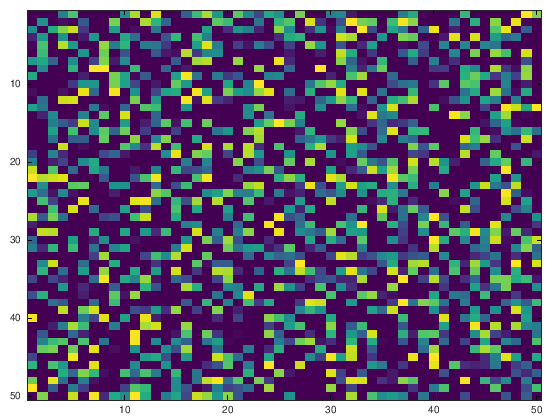

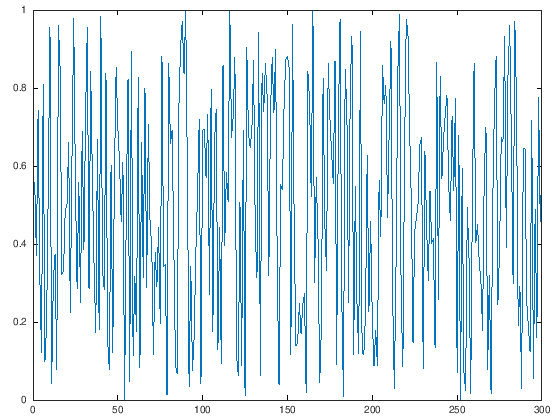

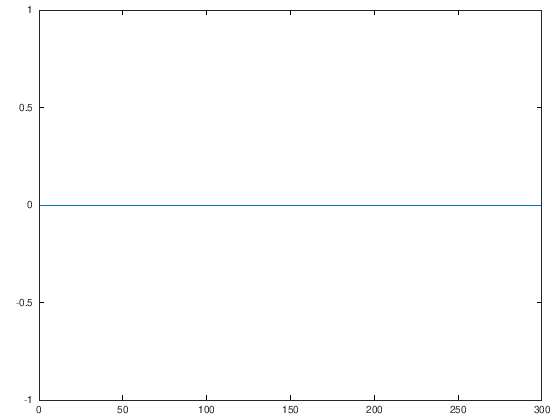

In [7]:
figure();
imagesc(A(1:50, 1:50));

figure();
plot(b);

figure();
plot(x0);

🐌 Raggiunto massimo numero di Iterazioni


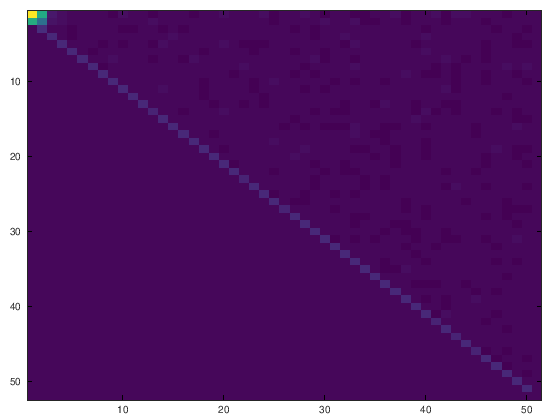

In [8]:
[x, res] = mygmres(A, b, x0, 50, 1e-10);

In [9]:
x
x_true = A\b
max(x_true-x)

x =

  -1.5988e-02
   1.9679e-02
   6.8196e-02
  -5.4277e-03
  -2.2284e-02
   8.8058e-03
  -1.0142e-02
   8.9331e-03
  -7.4107e-03
   1.0656e-02
  -2.9589e-02
   2.5662e-02
  -1.2659e-02
  -8.9614e-02
   4.6106e-03
  -9.4186e-03
  -1.3646e-02
  -3.3341e-02
   2.4914e-02
  -3.0541e-04
   1.5971e-02
   3.7384e-02
   1.2177e-02
   1.9394e-02
  -2.1301e-03
   1.9104e-03
  -1.3429e-02
   2.0210e-02
   1.3173e-02
   9.6206e-03
   2.3598e-02
  -3.5591e-03
  -2.1809e-02
   1.6008e-02
  -9.3330e-04
   2.5905e-02
   1.2094e-02
   3.0037e-02
  -9.7015e-03
   3.0653e-02
   1.3493e-02
   1.1854e-02
   9.7956e-03
   1.2715e-02
   3.7242e-02
  -1.6936e-02
   4.6700e-02
   2.8644e-02
   9.8020e-03
   1.6743e-02
   1.1461e-02
  -2.7865e-03
  -1.8973e-02
   1.0275e-02
   1.7969e-02
  -1.5836e-03
   1.5892e-02
   8.3726e-04
  -7.9172e-03
  -7.6164e-03
  -1.2929e-02
  -8.2796e-03
   1.6504e-02
  -1.9836e-02
   7.7715e-03
   1.4618e-02
   6.2747e-03
   4.3014e-03
   3.5323e-03
   2.5035e-02
  -1.2990e-02
 

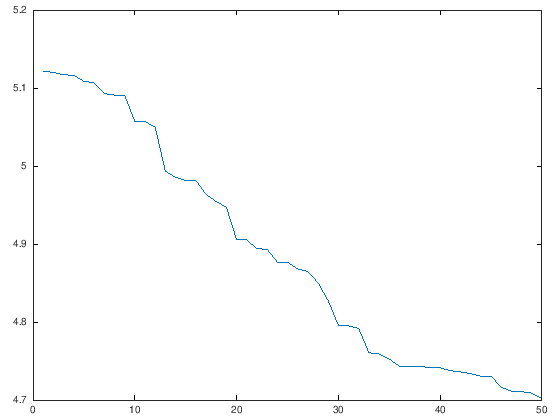

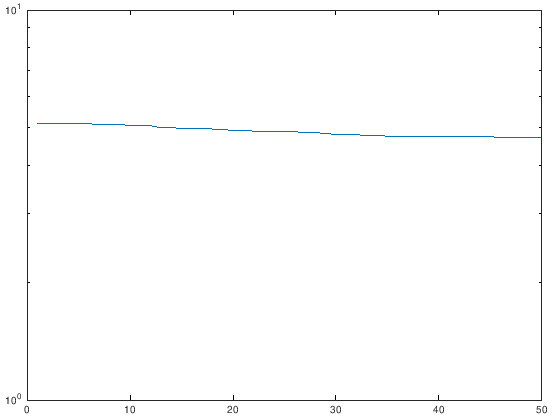

In [10]:
figure();
plot(res);

figure();
semilogy(res);

## Test 2 

Provo ad aumentare le dimensioni del sistema e vedere se cambia qualcosa.

In [11]:
[A, b, x0] = generateData(10000, .5);

🐌 Raggiunto massimo numero di Iterazioni


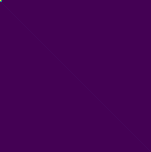

In [12]:
[x, res] = mygmres(A, b, x0, 150, 1e-10);

In [13]:
x
x_true = A\b
max(x_true-x)

x =

   1.1146e-03
  -1.3955e-03
   8.1334e-04
   4.6542e-04
   1.5644e-03
   8.6169e-04
  -1.9277e-03
  -1.9811e-04
  -8.0541e-04
   9.4501e-04
  -3.3165e-04
   6.2740e-04
   2.0299e-03
   5.4948e-04
   1.6673e-03
  -9.2200e-04
  -8.8907e-05
   3.4799e-04
  -9.2469e-04
  -3.4081e-04
   3.7992e-04
  -6.1490e-05
  -1.1425e-03
   3.1406e-04
  -1.5029e-03
   5.5370e-04
  -7.8700e-04
   1.2143e-03
  -1.8511e-03
  -8.4423e-04
   1.3420e-03
  -1.2829e-03
  -5.8321e-04
  -1.5971e-03
   2.5094e-03
   7.4345e-04
   3.9494e-04
   2.2500e-04
   7.2231e-04
   4.1430e-04
   5.4281e-04
   4.9497e-05
   2.7947e-05
   1.7575e-04
  -2.7507e-04
  -5.9839e-04
  -1.3118e-03
  -1.3470e-03
  -1.0197e-03
  -3.0642e-03
  -1.3381e-03
   1.3311e-05
   4.4746e-04
  -7.9253e-04
   2.2576e-04
   7.7068e-04
   1.6793e-03
   5.2728e-04
   2.0633e-04
  -9.1252e-04
   3.4121e-04
   1.1870e-03
  -1.4797e-03
   9.1379e-04
   1.5802e-03
  -1.7115e-04
  -9.4679e-05
   4.8412e-04
   1.0871e-03
  -7.5156e-04
   1.4731e-03
 

x_true =

  -5.2268e-01
  -3.6795e-01
   2.8069e-01
  -7.3381e-01
   2.8935e-01
   5.3752e-02
   4.1293e-01
   1.7619e-02
  -1.8587e-01
  -3.2723e-03
  -2.2705e-01
   5.4115e-01
  -5.1354e-01
  -2.6705e-01
  -1.9842e-01
   2.9717e-01
  -7.8059e-01
   7.7901e-01
   4.4515e-01
  -4.4893e-02
   8.2045e-01
  -1.2412e-01
  -7.6046e-01
   7.5613e-03
   5.9879e-01
   8.6827e-01
  -1.1219e-01
  -3.8075e-01
  -3.0014e-01
  -1.8248e-01
   8.1017e-01
   1.2477e-01
  -3.5212e-01
   4.4320e-01
  -2.7315e-01
   2.0394e-02
  -7.3869e-01
  -1.0619e-01
   7.4223e-02
  -3.6145e-01
  -5.1422e-01
  -7.2202e-02
  -2.1066e-01
  -2.0448e-01
   3.5715e-01
   3.3069e-01
  -4.2114e-01
  -4.9447e-01
   1.7710e-01
  -3.8431e-01
  -4.8432e-01
  -2.1036e-01
  -2.3788e-01
  -5.5216e-01
  -9.4713e-02
   4.1509e-01
   2.0263e-01
   3.4063e-01
   4.1236e-01
  -2.9108e-01
   7.0683e-01
   2.3278e-01
   8.1949e-02
  -5.1849e-01
  -5.3565e-01
  -7.9621e-01
   1.5254e-01
  -2.8987e-01
   2.0381e-03
   5.6801e-01
  -6.1392e

  -2.4523e-02
  -6.4685e-02
  -1.9639e-01
   7.1178e-02
  -1.1500e-01
  -1.7494e-01
  -6.2105e-02
   2.7332e-01
  -6.8472e-01
  -2.1748e-02
   1.0272e-01
  -3.3781e-01
  -2.1904e-01
   7.5716e-02
   2.4744e-01
  -5.3146e-02
  -3.4292e-01
   7.6921e-01
  -1.0328e-01
   7.1289e-02
  -7.5179e-01
   1.0840e-02
  -1.6826e-01
  -5.0502e-02
   5.4955e-01
   1.5551e-01
   5.8333e-01
   8.5888e-01
   3.2375e-01
   5.3162e-01
   1.7830e-01
  -3.3480e-01
  -6.2187e-02
   7.5605e-01
   1.3527e-01
  -7.1271e-01
  -2.7286e-01
   4.5578e-01
   3.7787e-01
   6.4723e-01
   1.0498e-01
  -6.8556e-01
  -5.9394e-02
   5.8510e-02
  -8.3650e-01
   2.2706e-01
  -3.7511e-01
  -3.3153e-01
  -2.7573e-01
   4.5695e-02
   3.6841e-01
  -1.7723e-01
  -1.1127e-01
   5.5271e-02
  -7.1999e-04
   8.8359e-01
  -2.1466e-01
  -3.0098e-01
   1.6888e-01
   3.3303e-01
  -1.0005e-01
  -5.1094e-01
   1.8835e-02
  -1.2294e-01
   1.3974e-01
   2.0419e-01
  -2.7008e-01
   3.1025e-01
  -1.3039e-01
  -3.1431e-01
  -6.3399e-02
  -6.5

  -9.2045e-02
   1.3091e-01
   5.2706e-01
  -1.1190e+00
  -5.3495e-01
  -2.6871e-01
  -1.0963e-01
   3.5291e-01
  -3.4202e-01
   4.0367e-01
   7.6629e-02
  -2.0528e-01
   4.4354e-01
  -2.3579e-02
   1.9486e-01
  -6.0062e-01
  -1.2237e-01
   2.7085e-01
   6.9023e-01
  -4.8581e-01
   2.5754e-01
   4.1874e-01
   2.2163e-01
   4.7760e-01
  -9.8180e-01
   4.6557e-01
  -2.7554e-01
  -9.3041e-02
  -2.2357e-02
  -6.6148e-01
   6.5500e-02
   3.8223e-01
   8.3730e-02
  -2.1333e-01
  -1.0650e-01
  -1.5118e-01
  -2.2625e-01
  -5.2215e-01
  -1.8313e-02
  -2.5133e-01
   7.0189e-02
   1.8221e-01
  -6.6713e-02
   5.5462e-01
  -1.5664e-01
  -8.5797e-01
  -4.7994e-02
   8.1806e-01
  -1.2751e-02
  -1.2747e-01
   3.4507e-02
  -1.7488e-01
  -8.5721e-02
  -1.5614e-01
   1.3416e-02
  -4.3771e-01
  -7.5390e-02
  -3.1134e-01
  -2.4366e-01
  -6.6450e-01
  -6.8152e-01
   7.1576e-02
   1.0544e-01
  -6.3631e-01
  -1.8462e-01
   4.6488e-01
  -5.0874e-01
  -2.0826e-01
   4.4501e-03
  -1.8064e-01
   7.4769e-01
   2.5

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




   4.7493e-01
   4.6315e-01
   3.0765e-01
   4.8891e-01
  -4.2174e-01
  -2.8674e-01
   5.0045e-01
  -1.4503e-01
   1.4306e-01
   2.0090e-02
  -6.2413e-01
  -4.3342e-01
  -2.8547e-01
  -3.2399e-01
  -1.0582e+00
   1.3763e-01
   5.3091e-02
  -6.5012e-01
   2.1737e-01
  -4.8819e-01
   8.5062e-01
   4.3121e-01
   2.4872e-01
  -2.2727e-01
  -4.0640e-01
   7.0003e-02
  -7.5645e-01
  -8.1270e-03
   4.4081e-01
  -4.0598e-02
   4.5207e-01
  -4.5362e-01
  -3.4121e-01
   1.1963e-01
   2.7909e-01
   9.1576e-01
   2.0836e-01
   6.1336e-01
  -1.3240e-01
   5.3137e-01
   2.1319e-01
   1.8574e-01
   1.6159e-01
   3.0746e-01
  -6.7268e-01
   3.1964e-03
   1.9234e-01
  -2.6442e-01
   1.7077e-01
  -1.3275e-01
   2.2334e-01
  -4.0409e-01
  -4.8232e-01
  -4.6697e-01
   1.4502e-01
  -9.9895e-02
   3.1837e-01
   1.0099e+00
   5.9994e-01
   7.2455e-01
   2.9475e-04
   3.9111e-02
  -5.5946e-01
   2.4447e-01
   3.7822e-01
  -7.5389e-01
   1.8915e-01
   2.5728e-01
   8.9490e-02
  -6.7673e-01
   7.9803e-01
  -8.

   3.4127e-01
   7.3561e-01
   3.6799e-04
   6.5677e-01
   2.4229e-01
   3.2382e-01
   8.4593e-01
   2.9456e-01
  -6.6853e-01
   3.1969e-01
   8.6496e-01
   1.3915e-01
   3.6488e-02
  -7.1824e-01
   3.1534e-01
   1.2063e-01
   2.2573e-01
  -4.1324e-01
  -6.1123e-01
  -5.3775e-01
   2.7373e-01
   1.0275e-01
   3.1210e-01
   3.7022e-01
  -9.4040e-02
   5.1477e-01
  -4.3292e-03
   6.5587e-01
   1.8948e-01
  -1.8160e-01
  -7.2125e-01
  -3.3678e-02
   1.8362e-01
   4.8942e-01
   5.4607e-02
  -2.1896e-01
  -4.3348e-01
  -6.2529e-01
   5.1034e-01
   2.3792e-01
  -8.5340e-02
  -4.4805e-01
   3.8277e-01
  -1.5250e-01
  -2.1883e-01
   1.4727e-02
   1.7167e-01
   3.7796e-01
   1.5285e-02
  -1.8371e-01
   2.2173e-01
   2.1598e-02
   8.4875e-02
  -1.9275e-01
  -3.6927e-01
   4.8403e-01
  -8.8181e-02
  -4.4759e-01
   4.4416e-01
  -3.3348e-01
  -2.8533e-01
  -6.2239e-01
   2.8509e-01
  -8.4646e-02
   4.2389e-01
  -3.2419e-01
   1.3607e-02
   7.8954e-01
   2.7082e-01
  -4.2018e-02
   1.3341e-01
   2.0

   2.0592e-01
   3.0822e-03
   2.1293e-02
  -4.8006e-01
   4.2026e-01
   6.2979e-01
   5.6413e-01
  -7.0187e-02
  -5.2959e-01
  -1.2954e-01
  -7.8628e-02
  -6.2137e-02
  -4.2931e-01
  -2.3117e-01
  -6.1773e-01
   3.6742e-01
  -1.0330e+00
   1.7963e-01
  -4.5269e-01
  -6.6214e-01
  -2.5219e-01
  -5.9924e-01
  -5.4623e-01
  -3.0661e-01
   4.9843e-01
  -8.9845e-01
   3.3372e-01
  -1.6459e-01
  -3.4105e-01
  -8.4242e-01
  -5.0408e-01
  -1.1456e-01
  -1.9410e-01
   9.0362e-01
  -6.9439e-01
  -1.6733e-01
   6.2437e-01
  -9.5627e-02
   2.9744e-01
   1.8275e-01
   1.5277e-01
   3.8707e-01
  -8.7526e-01
   1.4563e-02
  -4.4299e-01
   6.2994e-01
   7.5346e-02
   3.4327e-01
  -1.9022e-01
   2.3184e-01
   9.6568e-02
  -6.0254e-01
  -6.7381e-01
  -4.1975e-02
   1.3104e-01
   4.9039e-01
  -7.5858e-01
   5.6263e-01
  -3.2025e-01
   4.0043e-01
  -5.5612e-01
   2.9813e-01
   4.5793e-01
   5.4301e-01
  -2.4676e-01
   4.3928e-01
  -8.0000e-02
  -9.0224e-01
   1.0335e-01
  -6.0013e-01
   2.6929e-01
  -4.8

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




   2.2062e-01
   5.7917e-01
  -2.7832e-01
   1.8455e-01
   2.6595e-01
  -4.4600e-01
  -1.9831e-01
  -7.7043e-01
   2.1235e-01
  -6.2221e-01
  -1.0608e-01
  -4.9642e-01
  -2.4551e-01
  -4.6383e-01
   6.0270e-02
  -4.9665e-01
   2.3874e-01
   2.6088e-01
  -3.4914e-02
  -7.5128e-01
  -9.4564e-02
  -1.3387e-01
  -2.4646e-01
   6.5315e-01
  -3.0810e-01
   4.7204e-01
  -2.1687e-01
  -1.8393e-01
  -5.4716e-01
   1.8315e-01
  -3.1828e-01
  -5.0339e-01
   1.7108e-01
   7.7141e-01
  -1.9689e-01
  -5.0384e-01
  -6.0037e-01
   3.2772e-01
  -6.9707e-01
  -1.4444e-03
   7.4292e-01
   1.2794e-01
  -9.5602e-02
  -3.9447e-01
   4.6225e-02
   6.5694e-01
   5.0773e-01
  -1.0097e+00
   4.1881e-01
  -6.6825e-01
  -3.1790e-01
   2.1962e-01
   1.8529e-01
  -5.9554e-01
   3.3929e-02
   2.0269e-01
  -3.6660e-01
   5.3080e-01
   1.6228e-01
   2.8117e-01
   4.7758e-01
   3.0668e-01
  -3.4543e-02
   1.5632e-01
  -8.8567e-01
  -7.4387e-02
   2.1269e-01
  -4.3791e-01
  -3.0888e-01
   8.5238e-02
  -5.7693e-01
  -3.

  -8.2242e-01
   6.9992e-02
  -4.6543e-02
  -2.9989e-02
   8.6730e-02
  -8.0835e-01
   3.4471e-01
  -5.6583e-01
   6.5365e-02
  -2.5286e-01
   1.5967e-01
  -1.5238e-01
   5.1895e-01
  -1.3077e-01
   7.9596e-01
   5.4513e-01
  -7.2016e-02
  -5.0701e-02
   1.0617e-01
   4.7291e-01
  -8.4729e-01
   4.8807e-01
  -1.1535e-01
   1.5310e-01
  -1.5544e-02
  -4.4387e-02
   2.7936e-01
  -2.4982e-02
  -1.0347e-02
  -1.4151e-01
  -1.5494e-01
   4.3569e-01
   3.8080e-01
  -6.6585e-01
   1.4616e-01
   5.1225e-01
   3.8109e-01
   6.2453e-01
  -1.9733e-01
   2.6336e-02
   3.8171e-01
   4.0172e-01
  -5.3995e-01
   4.0615e-01
   9.6539e-01
  -1.9775e-01
   3.2167e-01
   7.6592e-02
  -3.5186e-01
   5.4288e-01
   5.0191e-03
  -4.2247e-01
  -1.0960e-01
  -1.8857e-01
  -4.4365e-01
   2.5787e-01
   3.2813e-02
  -2.8607e-01
  -2.7776e-01
  -2.7534e-01
  -3.6178e-01
   6.0442e-01
  -5.2604e-01
   1.2215e-01
  -2.6836e-01
  -3.5745e-01
  -1.1138e-02
   2.1953e-01
   5.5951e-01
  -7.8111e-02
   4.9393e-01
  -3.8

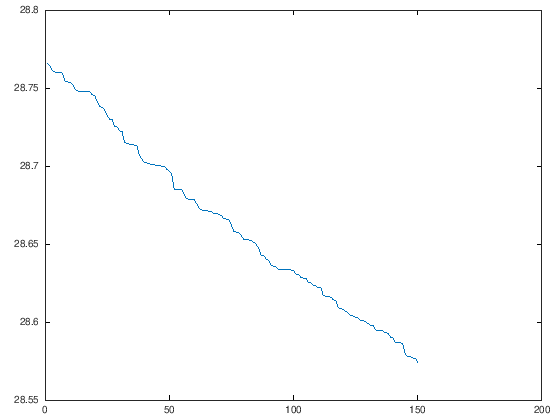

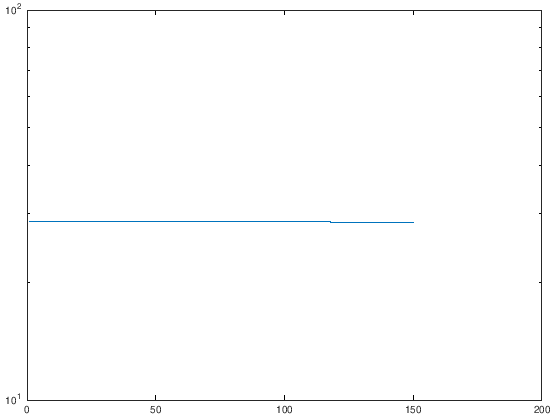

In [15]:
figure();
plot(res);

figure();
semilogy(res);

## Test 3

Analizzo le varie matrici che genero per capire quale proprietà hanno in comune.

In [16]:
function matrixInfo(matrix)
    figure();
    imagesc(matrix(1:50, 1:50));
    
    figure();
    plot(eig(matrix), 'o');
endfunction

Random Matrix of Size: 140
Random Matrix of Size: 374
Random Matrix of Size: 413
Random Matrix of Size: 482


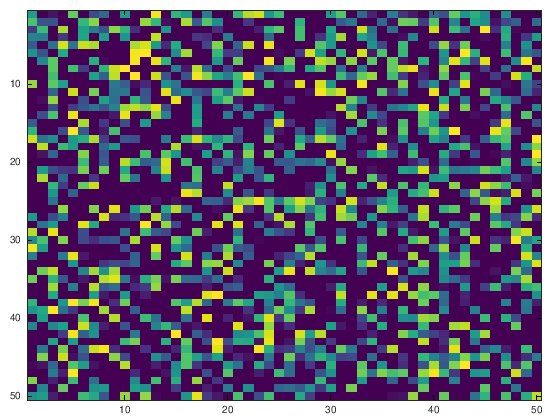

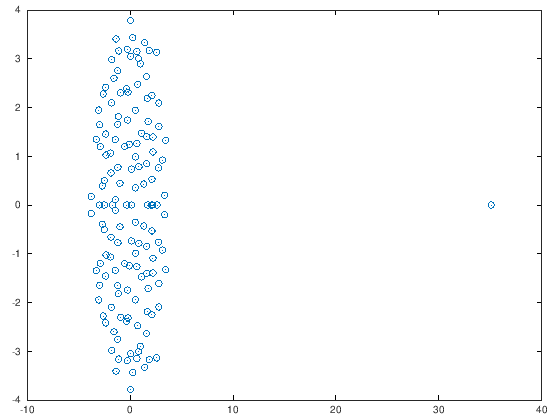

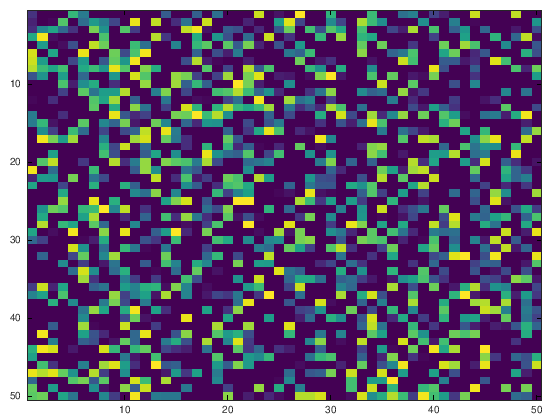

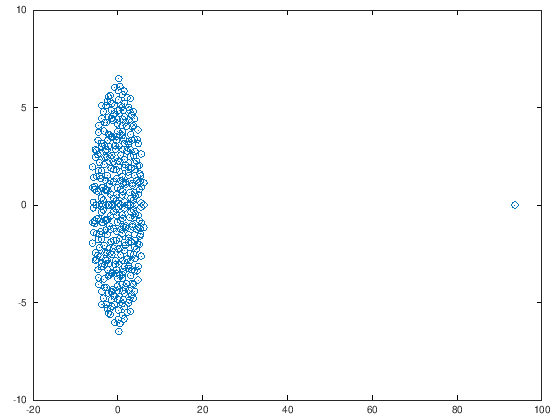

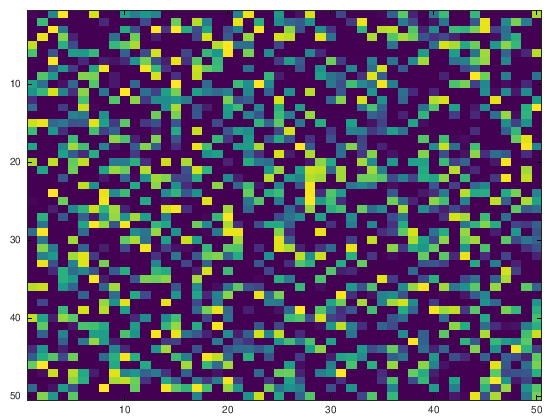

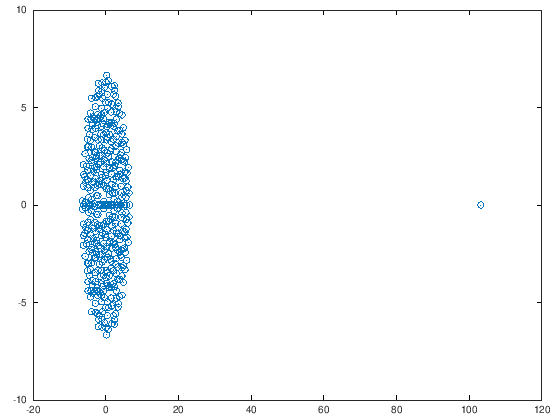

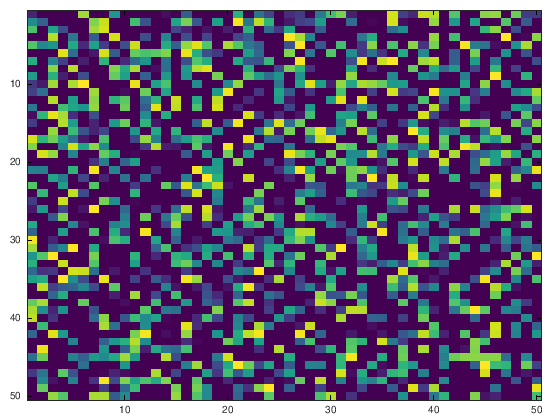

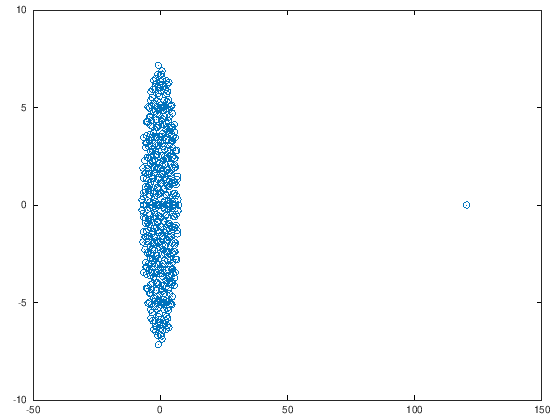

In [17]:
for _ = 1:4
    % 50 <= random size <= 800
    dim = randi([50 800], 1, 1);
    printf("Random Matrix of Size: %d\n", dim);
    
    [A, b, x0] = generateData(dim, .5);
    
    matrixInfo(A);
end

## Test 4

GMRES su matrice identità

error: Divisione per 0 !!
error: called from
    mygmres at line 34 column 13


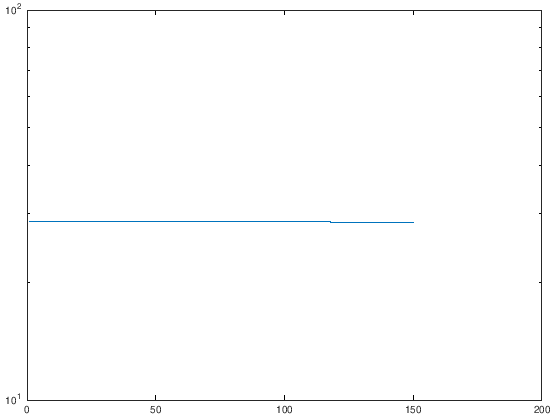

In [18]:
[A, b, x0] = generateData(300, .5);
A = eye(300);

[x, res] = mygmres(A, b, x0, 150, 1e-10);

figure();
semilogy(res);

## Test 5

GMRES con multiplo della matrice identità

🚀 Raggiunta Tolleranza, stop


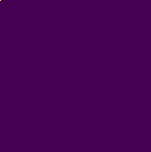

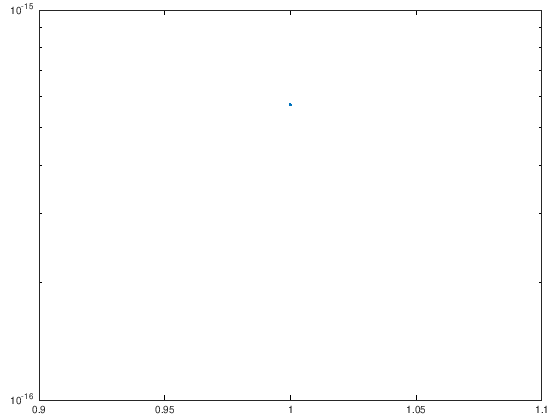

In [19]:
A = eye(300) * 5;

[x, res] = mygmres(A, b, x0, 150, 1e-10);

figure();
semilogy(res);

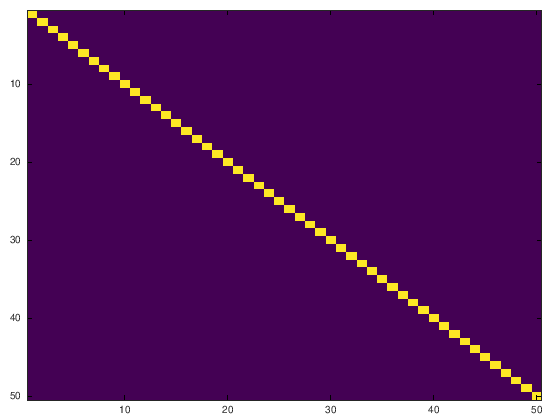

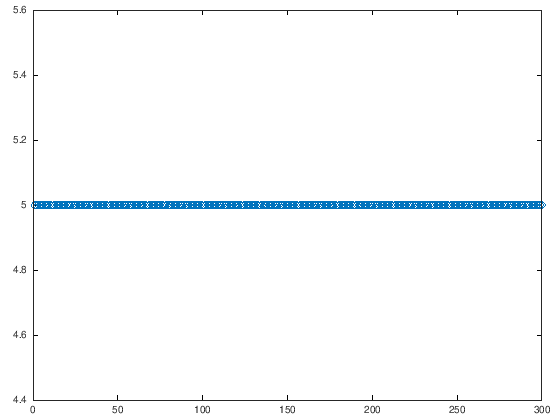

In [20]:
matrixInfo(A);

## Test 6

Matrice radom + multiplo identità

🐌 Raggiunto massimo numero di Iterazioni


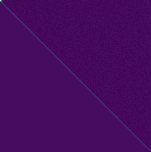

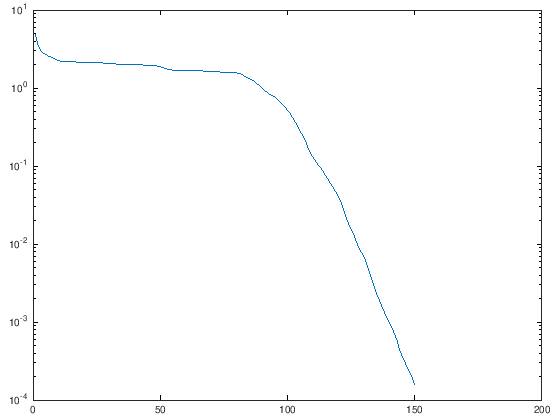

In [21]:
[A, b, x0] = generateData(300, .5);
A = A + eye(300)*5;

[x, res] = mygmres(A, b, x0, 150, 1e-10);

figure();
semilogy(res);

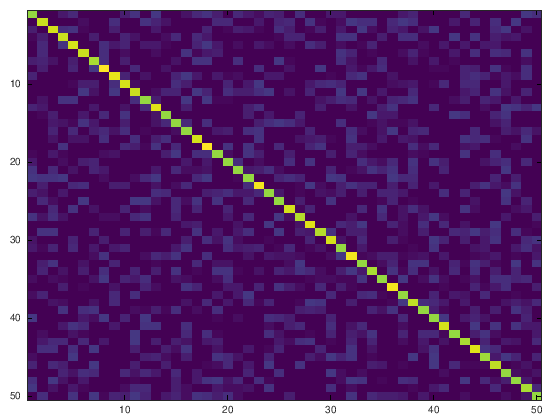

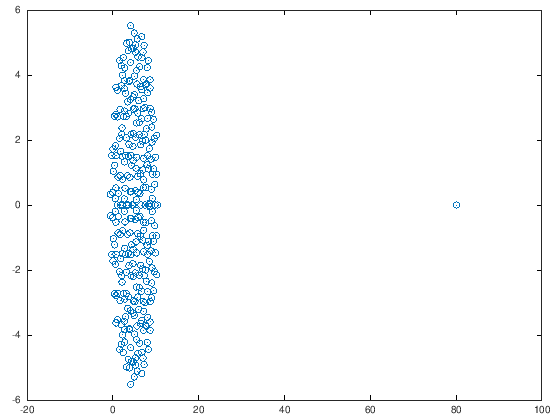

In [22]:
matrixInfo(A);

## Test 7

Multiplo Identità più una matrice con valori compresi tra 0 e 1

In [23]:
function [A b x0] = generateData2(dim, n=-4, seed=69, randx0=false)
    rand("seed", seed);
    mu = 0;
    sigma = 1/(2*sqrt(dim));
    A = n * eye(dim) + normrnd(mu, sigma, dim);
    b = ones(dim, 1);

    if (randx0)
        x0 = rand(dim, 1);
    else
        x0 = zeros(dim, 1);
    end
endfunction

🍌 n = -4
🚀 Raggiunta Tolleranza, stop
approx_error =    1.1427e-12
🍌 n = -2
🚀 Raggiunta Tolleranza, stop
approx_error =    3.2771e-12
🍌 n = 0
🐌 Raggiunto massimo numero di Iterazioni
approx_error =  90.625
🍌 n = 2
🚀 Raggiunta Tolleranza, stop
approx_error =    6.4820e-12
🍌 n = 4
🚀 Raggiunta Tolleranza, stop
approx_error =    1.0401e-12


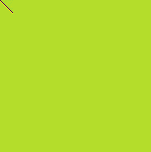

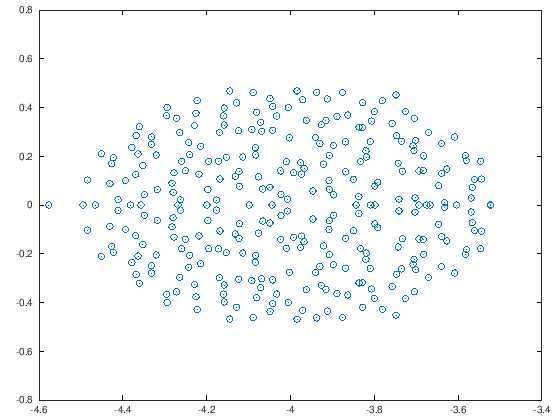

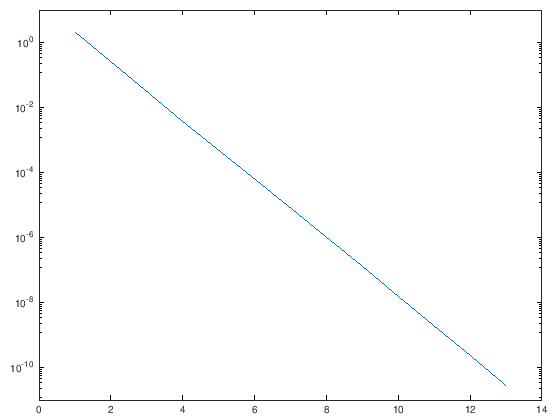

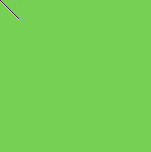

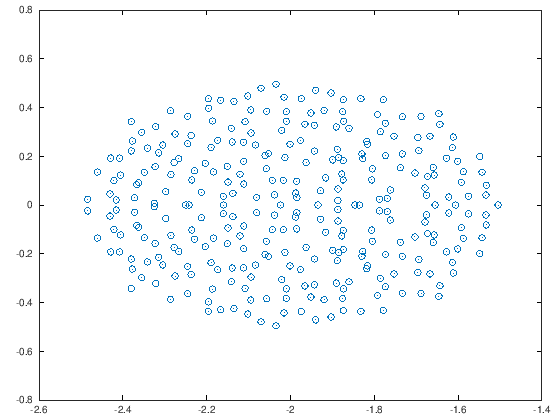

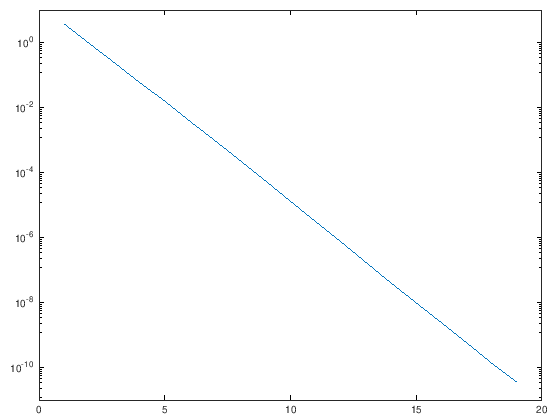

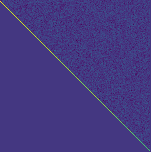

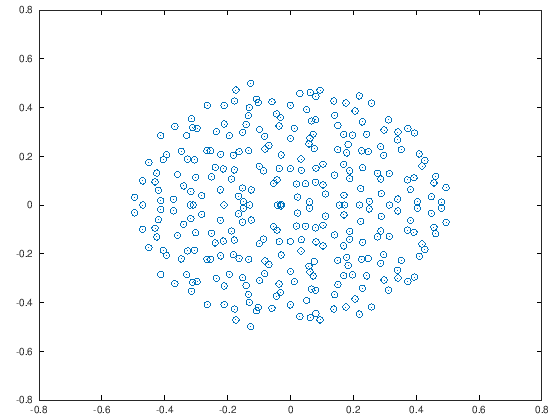

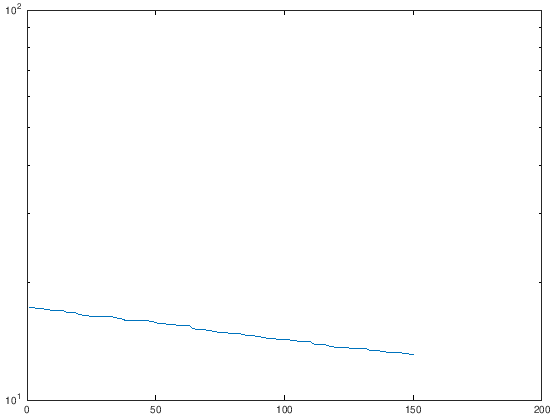

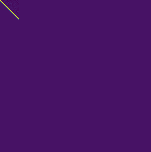

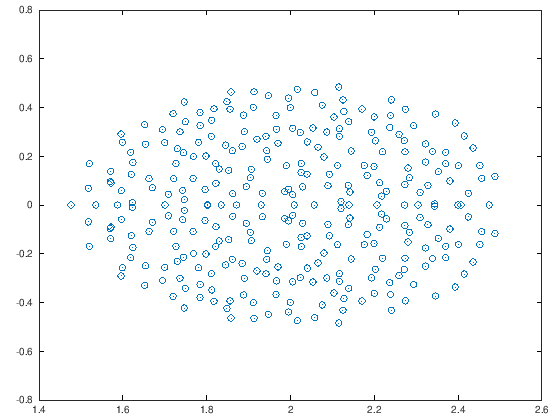

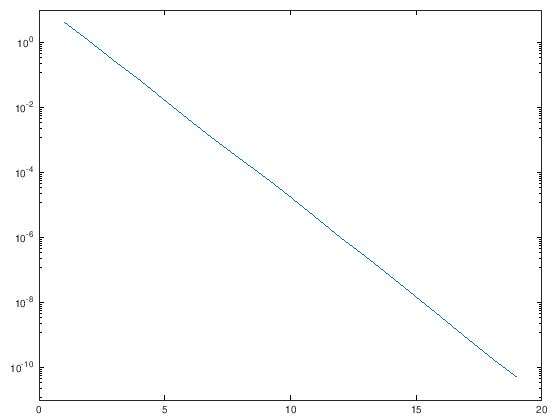

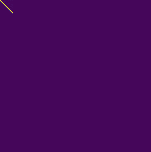

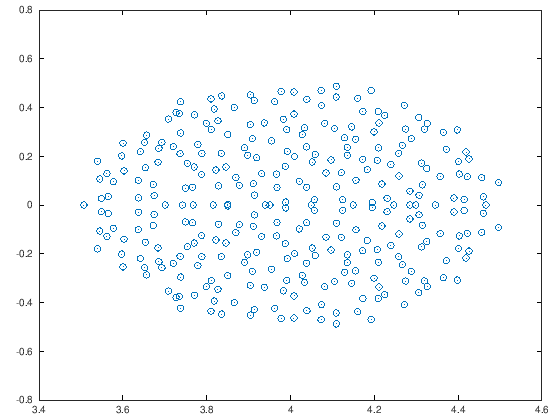

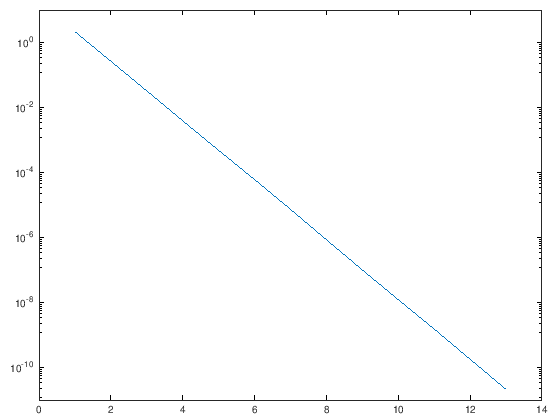

In [24]:
for n = [-4 -2 0 2 4]
    figure();
    printf("🍌 n = %d\n", n)
    
    [A, b, x0] = generateData2(300, n=n);
    [x, res] = mygmres(A, b, x0, 150, 1e-10);
    
    x_true = A\b;
    approx_error = max(x_true-x)
    
    figure();
    plot(eig(A), 'o');
    figure();
    semilogy(res);
end

🚀 Raggiunta Tolleranza, stop


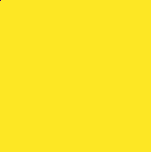

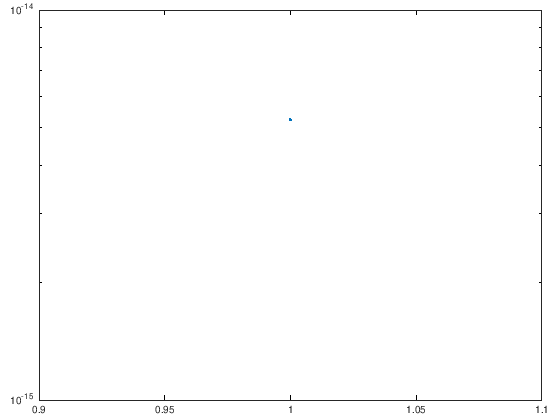

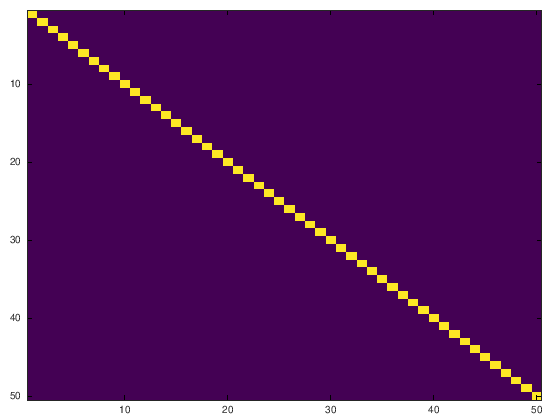

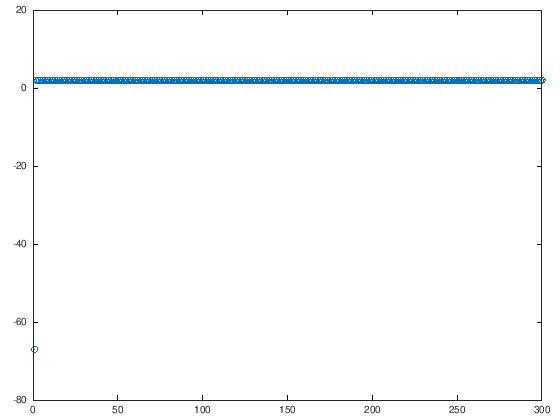

In [26]:
A = (zeros(300)-0.23) + eye(300)*2;
[x, res] = mygmres(A, b, x0, 150, 1e-10);

figure();
semilogy(res);

matrixInfo(A);

## Big Data

🐌 Raggiunto massimo numero di Iterazioni


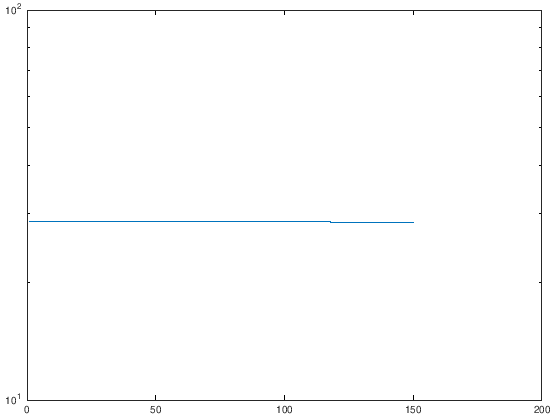

In [69]:
%%time
[A, b, x0] = generateData(10000, .5);
[x, res] = mygmres(A, b, x0, 150, 1e-10);
semilogy(res);

error: out of memory or dimension too large for Octave's index type
error: called from
    normrnd at line 87 column 11
    generateData2 at line 5 column 7
🚀 Raggiunta Tolleranza, stop


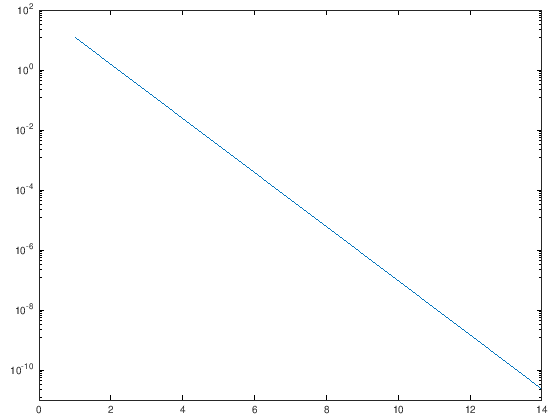

Time: 0.5863544940948486 seconds.



In [76]:
%%time
[A, b, x0] = generateData2(100000, n=4);
[x, res] = mygmres(A, b, x0, 150, 1e-10);
semilogy(res);

🐌 Raggiunto massimo numero di Iterazioni


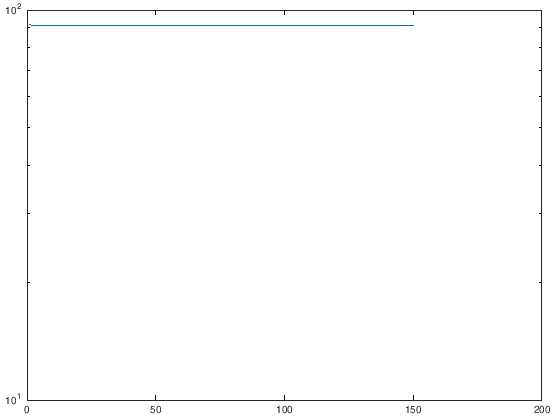

Time: 176.16767477989197 seconds.



In [78]:
%%time
[A, b, x0] = generateData(100000, .1);
[x, res] = mygmres(A, b, x0, 150, 1e-10);
semilogy(res);

In [27]:
function [A b x0] = generateData3(dim, dense, n=-4, seed=69, randx0=false)
    rand("seed", seed);

    A = sprandn(dim, dim, dense)*0.01 + speye(dim)*n ;
    b = ones(dim, 1);

    if (randx0)
        x0 = rand(dim, 1);
    else
        x0 = zeros(dim, 1);
    end
endfunction

Sparse Matrix with size: 124
Sparse Matrix with size: 585
Sparse Matrix with size: 409
Sparse Matrix with size: 149


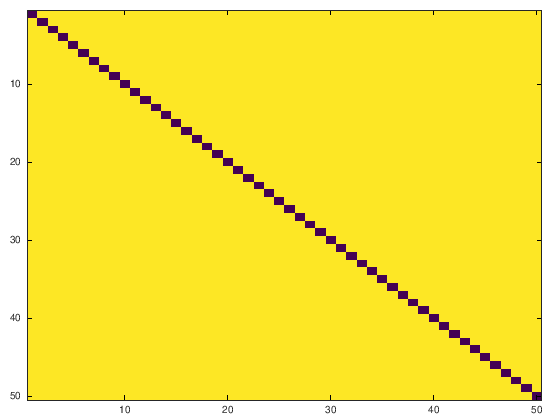

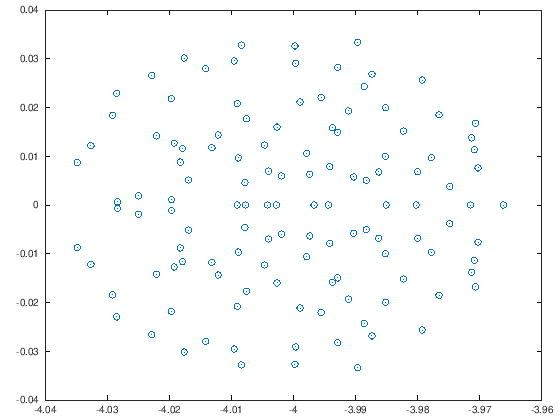

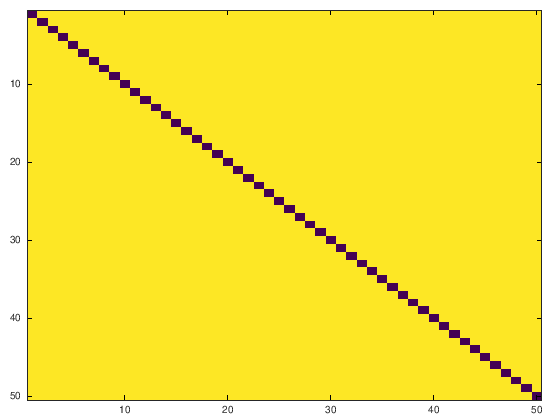

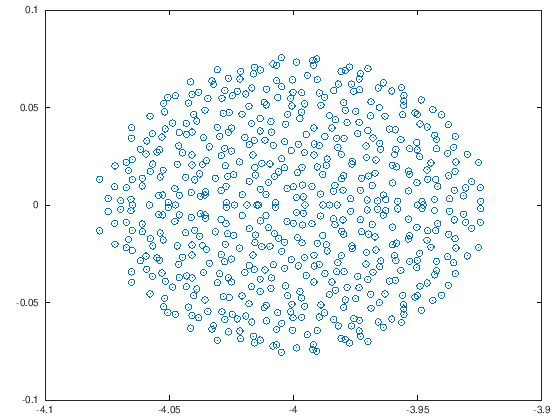

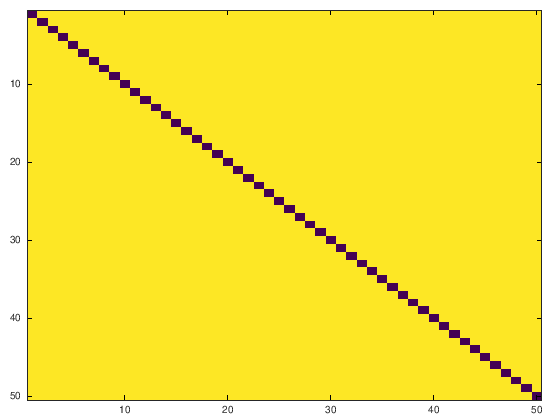

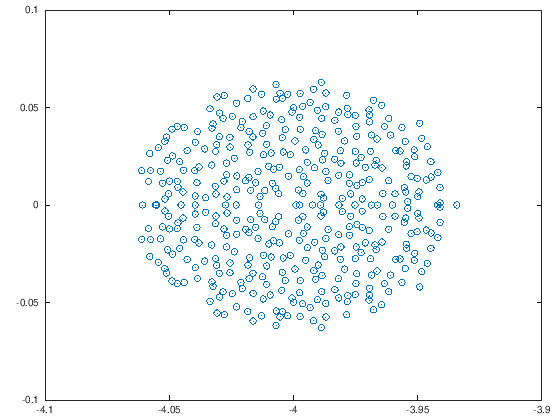

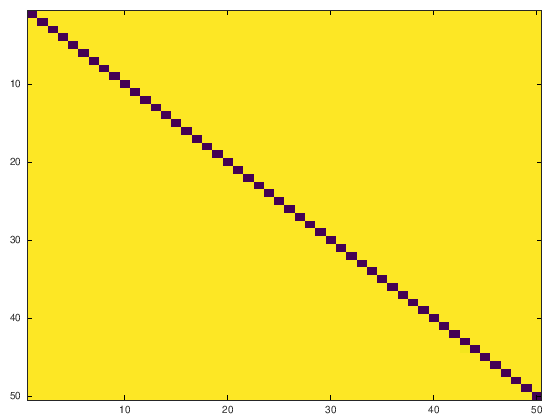

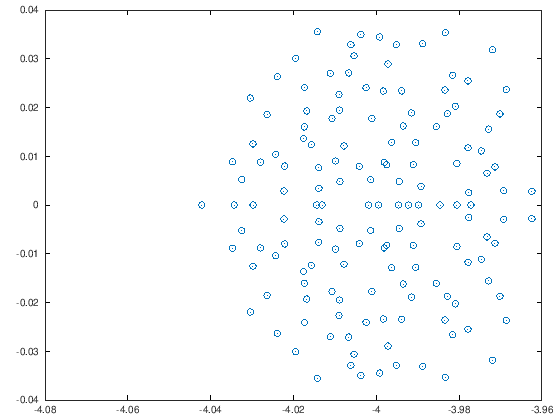

In [28]:
for _ = 1:4
    dim = randi([50 800], 1, 1);
    printf("Sparse Matrix with size: %d\n", dim);
    [A b x0] = generateData3(dim, .1);
    
    matrixInfo(A);
%     eigval = eig(A);
%     figure();
%     plot(eigval, 'o');
%     figure();
%     imagesc(A(1:50, 1:50));
end

🚀 Raggiunta Tolleranza, stop


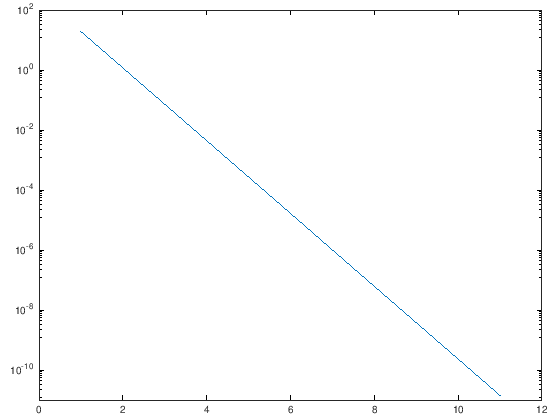

In [176]:
%%time
[A b x0] = generateData3(100000, .1);
[x, res] = mygmres(A, b, x0, 150, 1e-10);
semilogy(res);

## GMRES(m)

In [14]:
function [x res] = myrgmres(A, b, x0, k, tol, m)
    restartCount = 0;
    res = [];
    n = size(b)(1);
    en = zeros(k+2, 1);
    en(1) = 1;
    Q = zeros(n, k+1);

    while (restartCount < m)
        H = zeros(k+2, k+1);

        r0 = b - A * x0;
        beta = norm(r0, 2);
        Q(:, 1) = r0/norm(r0, 2);

        for j = 1:k
            v = A*Q(:, j);   
            for i = 1:j
                H(i,j) = Q(:,i)' * v;
                v = v - H(i, j) * Q(:, i);
            end
            
%             v =  gramschmidt(v);
            v = mgorth(v, Q);  % equivalente a quella sopra
            
            H(j+1, j) = norm(v, 2);
            
            if (H(j+1, j) == 0)
                error("Divisione per 0 !!");
            end
        
            Q(:, j+1) = v / H(j+1, j);
            
%             if (abs(H(j+1, j)) > tol)
%                 Q(:, j+1) = v / H(j+1, j);
%             end

            e1 = en(1:j+2);

            y =(H(1:j+2,1:j+1))\(beta *e1);
            res = [res norm(H(1:j+2,1:j+1)*y - beta*e1, 2)];

            if (res(end) < tol)
                x = Q(:, 1:j+1)*y +x0;
                disp('🚀 Raggiunta Tolleranza, stop');
                imagesc(H(1:j, 1:j));
                return;
            end
        end
        
        x = Q(:, 1:j+1)*y +x0;
        x0 = x;
        restartCount = restartCount + 1;
        
        disp('🐌 Raggiunto massimo numero di Iterazioni');
        disp('🗿 Restarting ...');
%         imagesc(H);
    end
    
    disp('❌ Raggiunto massimo numero di Restart');
    imagesc(H);
endfunction

🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🚀 Raggiunta Tolleranza, stop


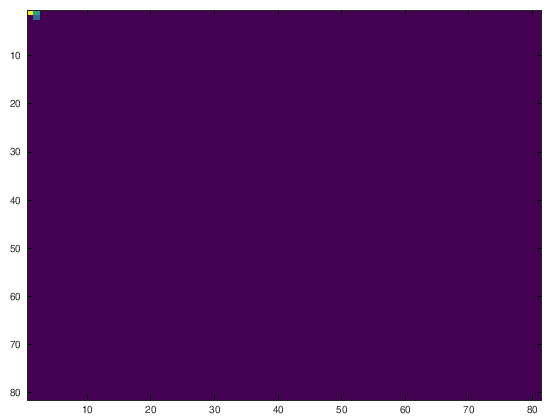

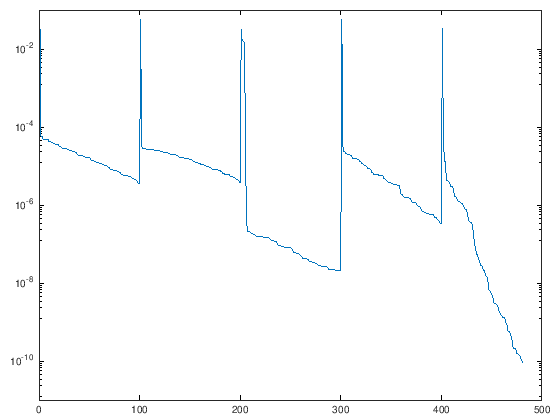

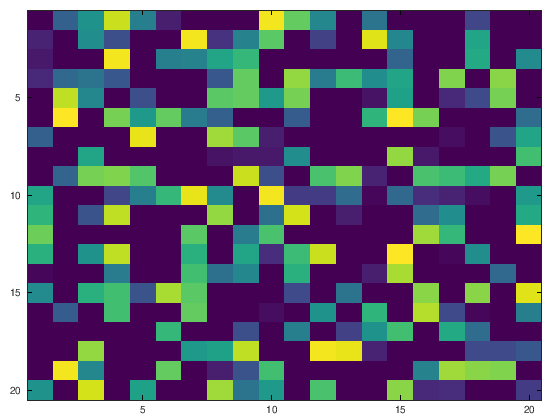

In [15]:
[A, b, x0] = generateData(9000, .5);

figure();
[x, res] = myrgmres(A, b, x0, 100, 1e-10, 10);

figure();
semilogy(res);

figure();
imagesc(A(1:20, 1:20));
% A(1:10, 1:10)

🚀 Raggiunta Tolleranza, stop


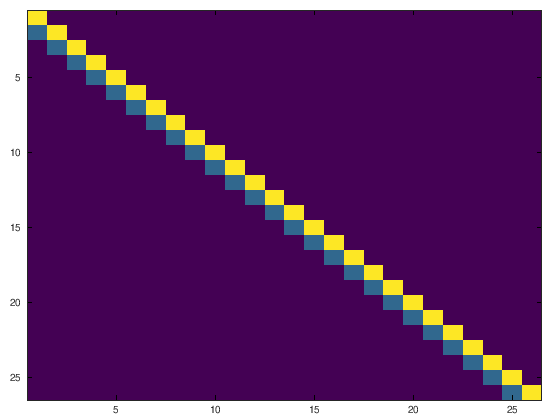

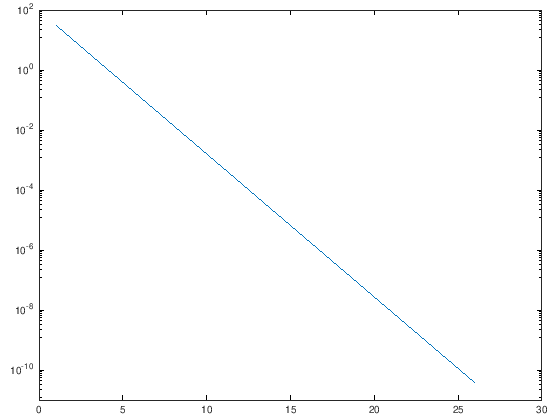

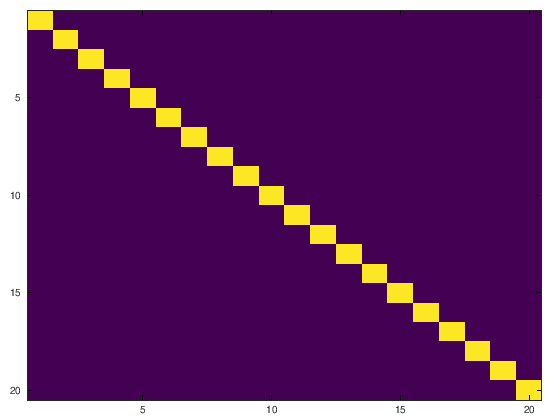

In [16]:
[A, b, x0] = generateData2(10000, 3);

figure();
[x, res] = myrgmres(A, b, x0, 100, 1e-10, 10);

figure();
semilogy(res);

figure();
imagesc(A(1:20, 1:20));
% A(1:10, 1:10)

🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🚀 Raggiunta Tolleranza, stop


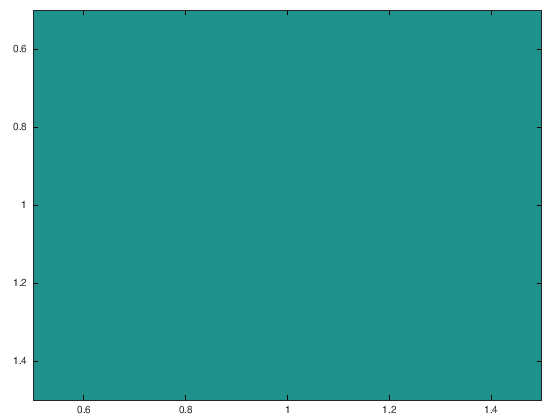

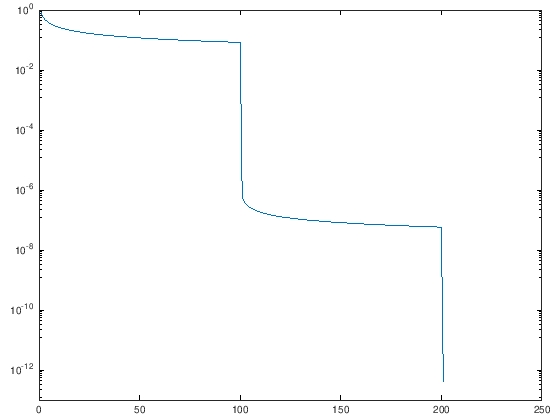

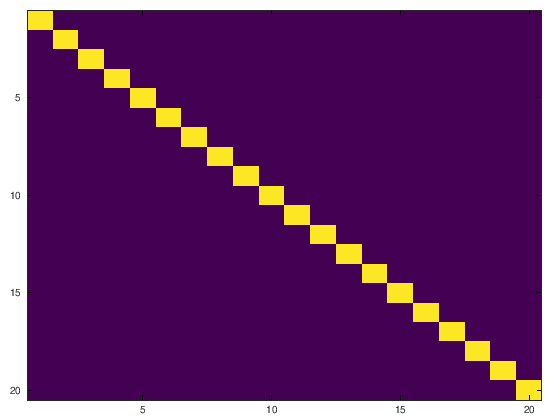

In [17]:
A = eye(10000)*120;

figure();
[x, res] = myrgmres(A, b, x0, 100, 1e-10, 10);

figure();
semilogy(res);

figure();
imagesc(A(1:20, 1:20));
% A(1:10, 1:10)

🚀 Raggiunta Tolleranza, stop


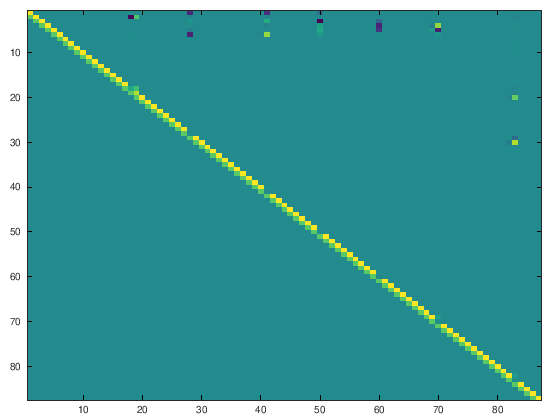

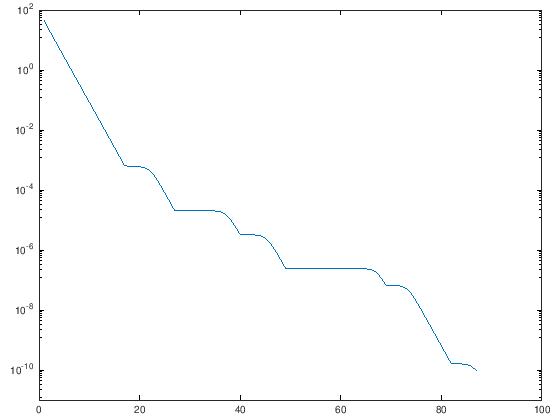

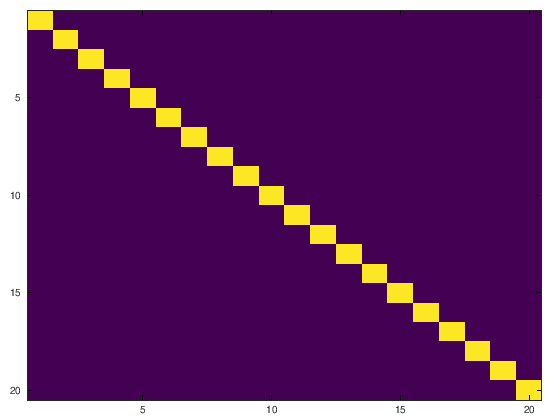

In [18]:
A = (ones(10000)-0.999999999999) + eye(10000)*2;

figure();
[x, res] = myrgmres(A, b, x0, 100, 1e-10, 10);

figure();
semilogy(res);

figure();
imagesc(A(1:20, 1:20));
% A(1:10, 1:10)

🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🚀 Raggiunta Tolleranza, stop


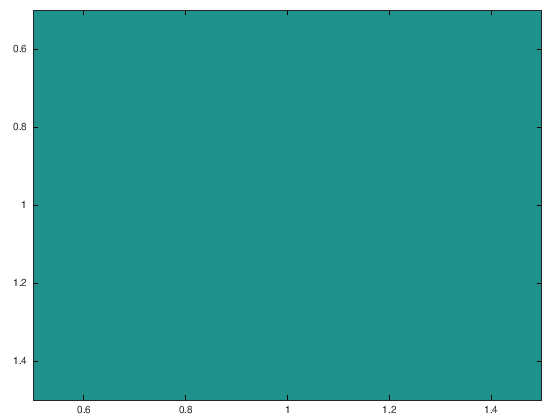

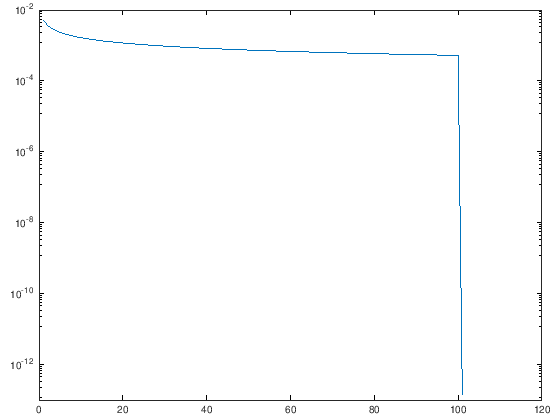

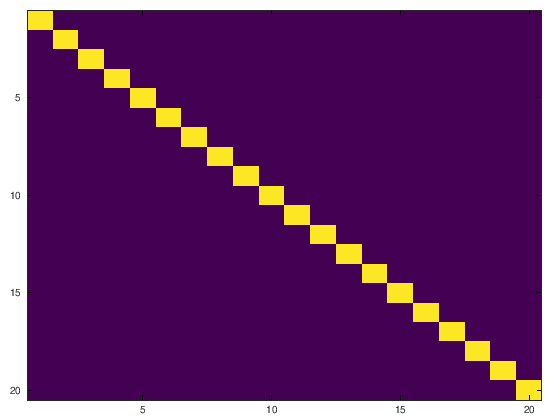

In [19]:
A = (ones(10000)+.9) + eye(10000)*3;

figure();
[x, res] = myrgmres(A, b, x0, 100, 1e-10, 10);

figure();
semilogy(res);

figure();
imagesc(A(1:20, 1:20));
% A(1:10, 1:10)

🍌 n = -4
🚀 Raggiunta Tolleranza, stop
approx_error =  0.10354
normm =  1.8805
🍌 n = -2
🚀 Raggiunta Tolleranza, stop
approx_error =  0.41524
normm =  4.1312
🍌 n = 0
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo nume

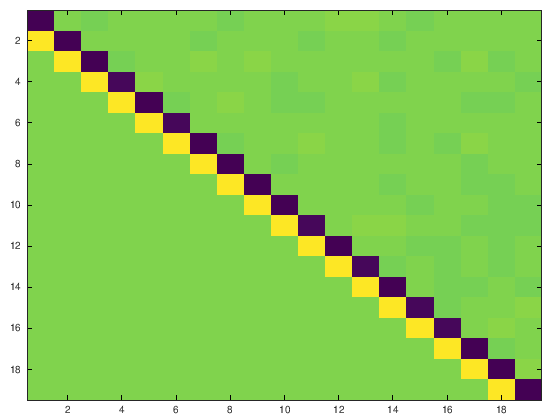

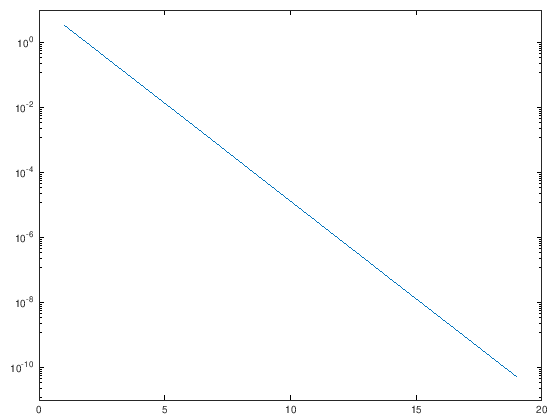

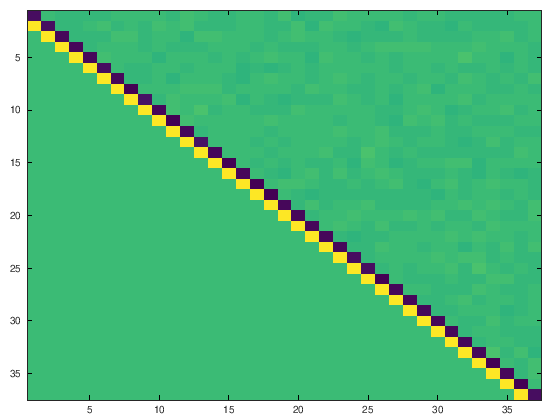

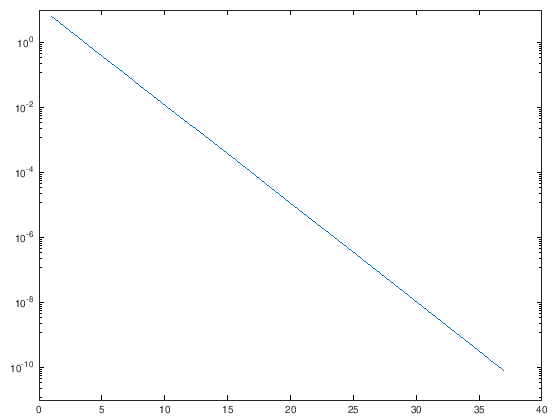

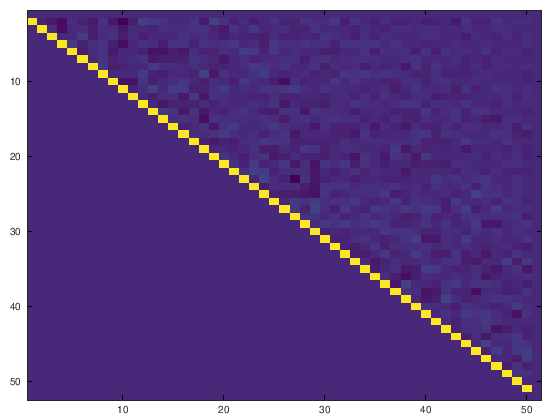

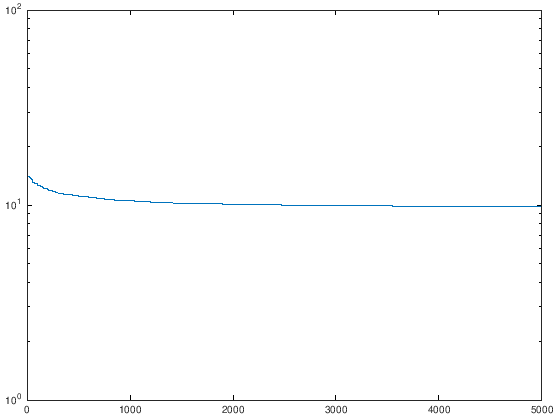

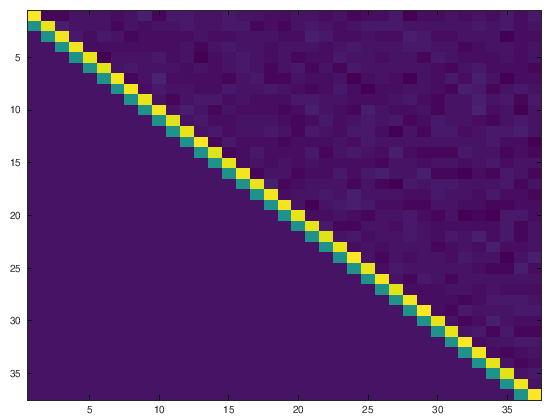

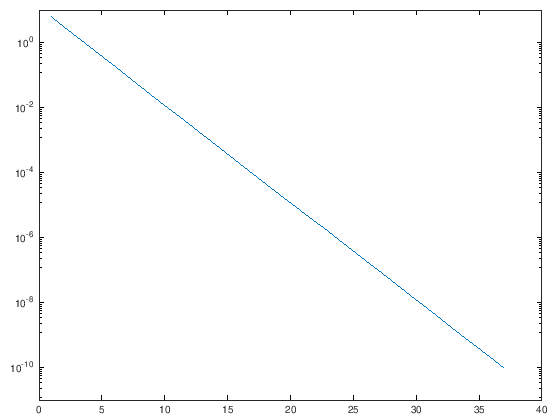

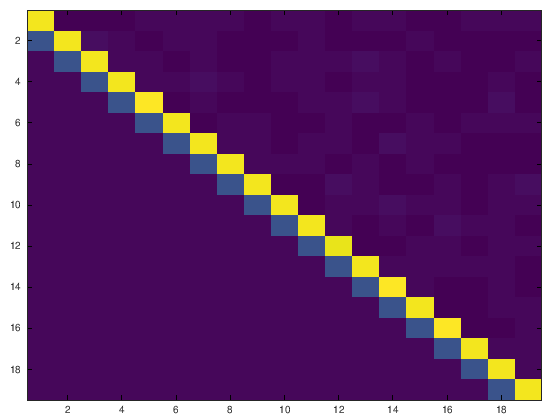

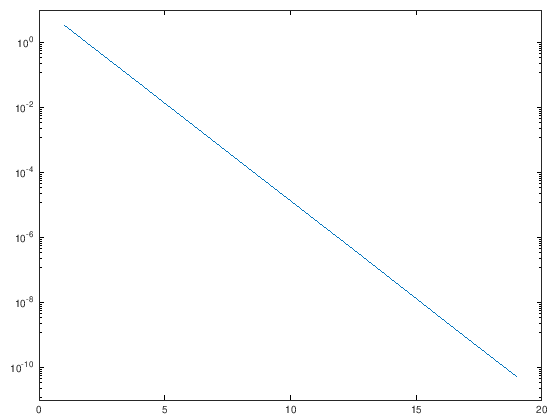

In [20]:
for n = [-4 -2 0 2 4]
    figure();
    printf("🍌 n = %d\n", n)
    [A, b, x0] = generateData2(200, n=n);
    [x, res] = myrgmres(A, b, x0, 50, 1e-10, 100);
    
    % x;
    x_true = A\b;
    approx_error = max(x_true-x)
    normm = norm(A*x - b)
    
    figure();
    title(["GMRES with n = " mat2str(n)]);
    semilogy(res);
end